Name: Arya Sun, Github Username: fearofhelicopter, USC ID: 8111052837

1. Decision Trees as Interpretable Models

(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, cross_val_score

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

In [2]:
path1 = '../data/diagnosis.data'
attributes = ["temperature", "nausea", "lumbar", "urine", "micturition", "burning", "inflammation", "nephritis"]
df = pd.read_table(path1, names = attributes, sep = "\t", decimal = ",",encoding = 'utf-16')

df = df.replace({"no": 0, "yes": 1})

df['temperature'] = pd.to_numeric(df['temperature'])

decisions = ["inflammation", 'nephritis']
features = [col for col in df.columns if col not in ['inflammation', 'nephritis']]

df

,temperature,nausea,lumbar,urine,micturition,burning,inflammation,nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


(b) Build a decision tree on the whole data set and plot it.

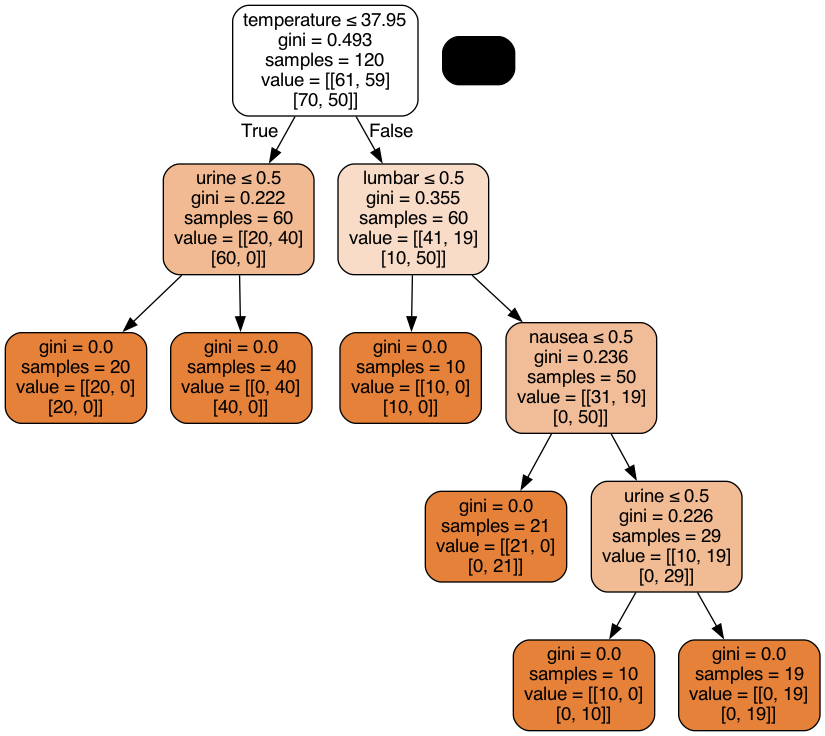

In [3]:
tree = DecisionTreeClassifier()
tree.fit(df[features], df[decisions])

tree1 = export_graphviz(tree, out_file = None, filled = True, rounded = True, special_characters = True,
                        feature_names = features, class_names = ['0','1'])
graph1 = pydotplus.graph_from_dot_data(tree1)
Image(graph1.create_png())

(c) Convert the decision rules into a set of IF-THEN rules.

In [4]:
#https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {} then:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else if {} > {} then:".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(tree, features)

def tree(temperature, nausea, lumbar, urine, micturition, burning):
  if temperature <= 37.95000076293945 then:
    if urine <= 0.5 then:
      return [[20.  0.]
 [20.  0.]]
    else if urine > 0.5 then:
      return [[ 0. 40.]
 [40.  0.]]
  else if temperature > 37.95000076293945 then:
    if lumbar <= 0.5 then:
      return [[10.  0.]
 [10.  0.]]
    else if lumbar > 0.5 then:
      if nausea <= 0.5 then:
        return [[21.  0.]
 [ 0. 21.]]
      else if nausea > 0.5 then:
        if urine <= 0.5 then:
          return [[10.  0.]
 [ 0. 10.]]
        else if urine > 0.5 then:
          return [[ 0. 19.]
 [ 0. 19.]]


(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

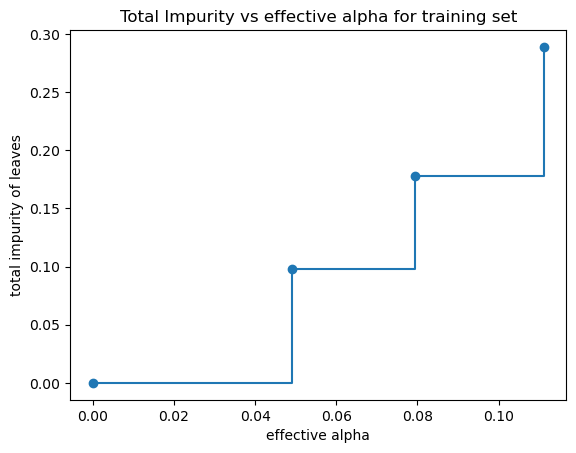

In [5]:
path = tree.cost_complexity_pruning_path(df[features], df[decisions])
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.204236111111111


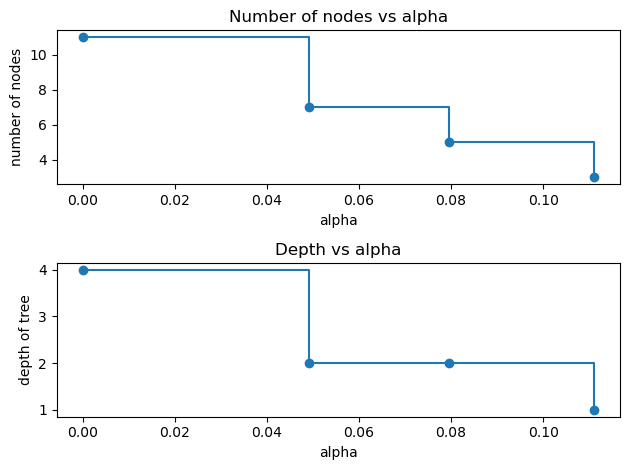

In [6]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(df[features], df[decisions])
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

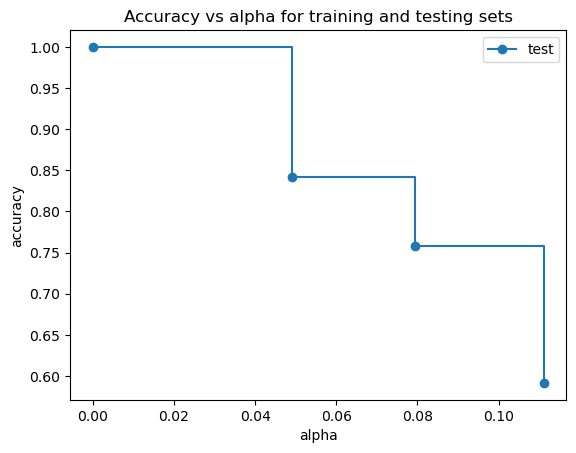

In [7]:
test_scores = [clf.score(df[features], df[decisions]) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [8]:
# # Create the decision tree classifier
# tree = DecisionTreeClassifier(random_state=42)

# # Train the decision tree on the data
# tree.fit(df[features], df[decisions])

# # Determine the values of alpha to use for pruning
# path = tree.cost_complexity_pruning_path(df[features], df[decisions])
# ccp_alphas = path.ccp_alphas
# impurities = path.impurities

# Loop through the different alpha values and train a decision tree for each one
best_accuracy = 0
best_tree = None
for alpha in ccp_alphas:
    # Create a decision tree for this alpha value
    pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    pruned_tree.fit(df[features], df[decisions])

    # Evaluate the accuracy of the decision tree
    accuracy = pruned_tree.score(df[features], df[decisions])
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_tree = pruned_tree

tree_to_code(best_tree, features)

def tree(temperature, nausea, lumbar, urine, micturition, burning):
  if temperature <= 37.95000076293945 then:
    if urine <= 0.5 then:
      return [[20.  0.]
 [20.  0.]]
    else if urine > 0.5 then:
      return [[ 0. 40.]
 [40.  0.]]
  else if temperature > 37.95000076293945 then:
    if lumbar <= 0.5 then:
      return [[10.  0.]
 [10.  0.]]
    else if lumbar > 0.5 then:
      if micturition <= 0.5 then:
        return [[21.  0.]
 [ 0. 21.]]
      else if micturition > 0.5 then:
        if urine <= 0.5 then:
          return [[10.  0.]
 [ 0. 10.]]
        else if urine > 0.5 then:
          return [[ 0. 19.]
 [ 0. 19.]]


2. The LASSO and Boosting for Regression

(a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [9]:
path2 = "../data/communities.data"
df = pd.read_csv(path2, names = list(range(0, 128)), na_values='?')

# Drop first 5 columns
df = df.iloc[:, 5:]

# Replace missing values with column medians
df.fillna(df.median(), inplace=True)

# Convert columns to numeric
df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric)

# Split data into training and test sets
train_X = df.iloc[:1495, :-1]
train_Y = df.iloc[:1495, -1]
test_X = df.iloc[1495:, :-1]
test_Y = df.iloc[1495:, -1]

(c) Plot a correlation matrix for the features in the data set.

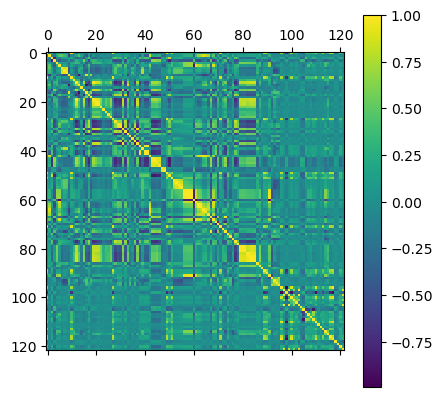

In [10]:
df = df.iloc[:, :-1]
corr_matrix = df.corr()

plt.matshow(corr_matrix)
plt.colorbar()
plt.show()

(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [11]:
cv_table = df.apply(lambda x: x.std() / x.mean()).to_frame(name = 'CV')
cv_table.sort_values(by = 'CV', ascending = False, inplace = True)

cv_table

,CV
113,5.447835
95,4.407702
94,3.485481
54,2.994196
56,2.900497
...,...
116,0.143227
109,0.126354
123,0.117979
110,0.117372


(e) Pick ⌊128⌋ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [12]:
#sqrt(128) = 11
top_features = cv_table.head(11)

top_features

,CV
113,5.447835
95,4.407702
94,3.485481
54,2.994196
56,2.900497
125,2.555266
32,2.304970
5,2.203503
101,2.080712
15,2.001744


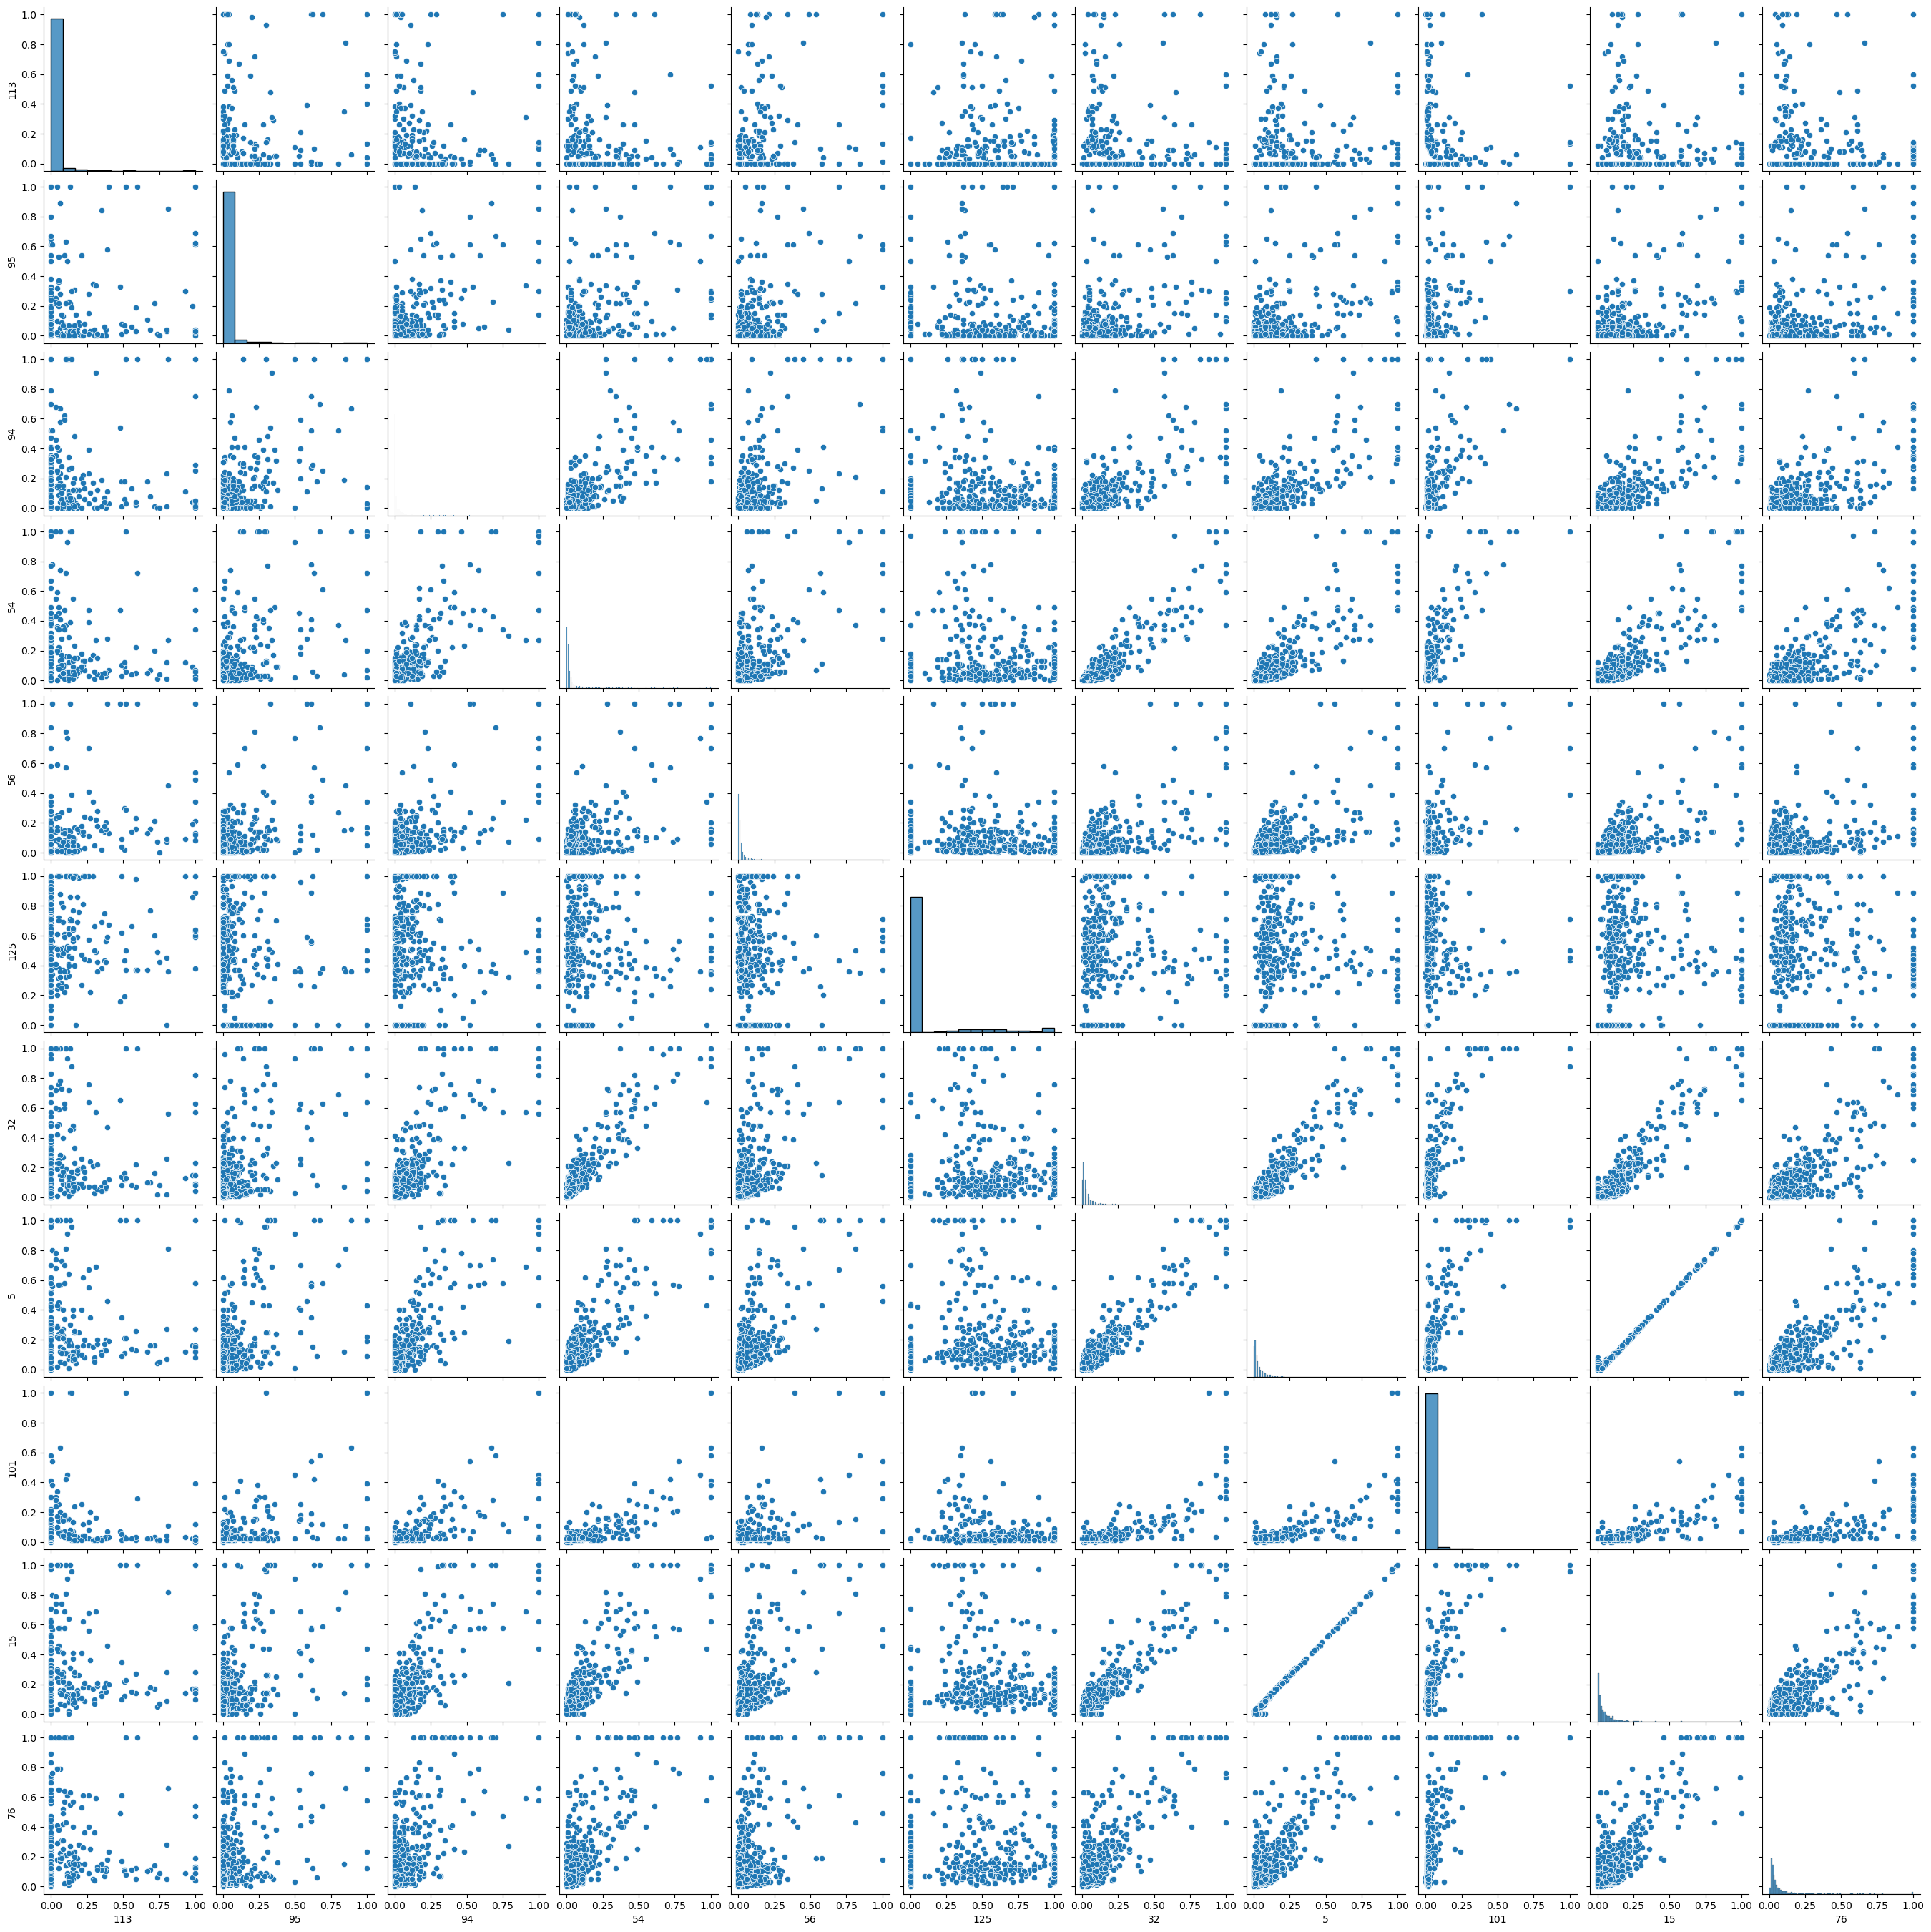

In [13]:
sns.pairplot(df[top_features.index.values])

<AxesSubplot:>

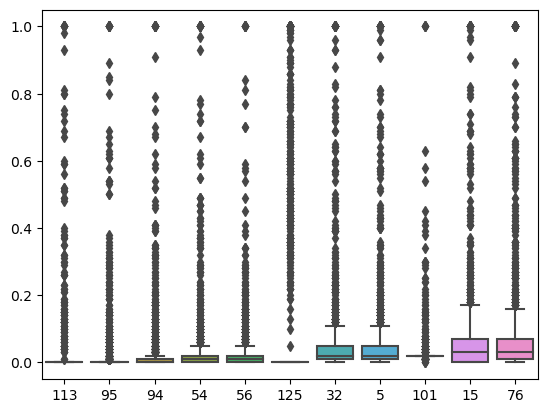

In [14]:
sns.boxplot(data=df[top_features.index.values])

There is significance of those features between #5population and #15numbUrban.

(f) Fit a linear model using least squares to the training set and report the test error.

In [15]:
linearReg = LinearRegression()
linearReg.fit(train_X, train_Y)
y_pred1 = linearReg.predict(test_X)

print("Linear test error:", mean_squared_error(test_Y, y_pred1))

Linear test error: 1.7579716884024877e+17


In [16]:
model = sm.OLS(train_Y, train_X).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    127   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                              68.33
Date:                Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                        23:23:30   Log-Likelihood:                          956.05
No. Observations:                1495   AIC:                                     -1670.
Df Residuals:                    1374   BIC:                                     -1028.
Df Model:                         121                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [17]:
ridgeReg = RidgeCV(cv = 5)
ridgeReg.fit(train_X, train_Y)
y_pred2 = ridgeReg.predict(test_X)

print("Ridge test error:" , mean_squared_error(test_Y, y_pred2))

Ridge test error: 0.017630963071705735


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [18]:
lasso = LassoCV(cv=5, max_iter=10000)
lasso.fit(train_X, train_Y)
y_pred3 = lasso.predict(test_X)
print("Lasso test error:" , mean_squared_error(test_Y, y_pred3))

selected_variables = train_X.columns[lasso.coef_ != 0]
print("Selected variables:", list(selected_variables))

#standardized features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

lasso_std = LassoCV(cv=5, max_iter=10000)
lasso_std.fit(X_train, train_Y)
y_pred_std = lasso_std.predict(X_test)
print("Lasso test error with standardized features:", mean_squared_error(test_Y, y_pred_std))

selected_vars_std = train_X.columns[lasso_std.coef_ != 0]
print("Selected variables with standardized features:", list(selected_vars_std))

Lasso test error: 0.017619962821141737
Selected variables: [7, 9, 11, 12, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 41, 43, 44, 45, 49, 50, 51, 53, 54, 55, 56, 57, 60, 64, 66, 68, 69, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 90, 91, 92, 93, 94, 95, 96, 97, 99, 104, 107, 109, 111, 112, 113, 116, 117, 118, 119, 120, 121, 123, 124]
Lasso test error with standardized features: 0.01768308528734958
Selected variables with standardized features: [7, 9, 11, 12, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 43, 44, 45, 49, 50, 51, 53, 54, 55, 56, 58, 60, 64, 66, 68, 69, 72, 73, 74, 76, 77, 79, 80, 81, 82, 83, 87, 90, 91, 92, 93, 94, 95, 96, 99, 104, 105, 107, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 123, 124]


Lasso test error is slightly lower than the Lasso test error with standardized features.

(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [19]:
pca = PCA()
X_reduced = pca.fit_transform(scale(train_X))
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

score = -1*cross_val_score(regr,
           np.ones((len(X_reduced),1)), train_Y, cv=cv,
           scoring='neg_mean_squared_error').mean()
mse.append(score)

for i in np.arange(1, train_X.shape[1]+1):
    score = -1*cross_val_score(regr,
               X_reduced[:,:i], train_Y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Find the optimal number of principal components
optimal_n_comp = np.argmin(mse) + 1
print("M:", optimal_n_comp)

# Fit the model using the optimal number of principal components
X_reduced_optimal = X_reduced[:,:optimal_n_comp]
lr_pcr = LinearRegression()
lr_pcr.fit(X_reduced_optimal, train_Y)

# Compute the test error
X_test_reduced = pca.transform(scale(test_X))
X_test_reduced_optimal = X_test_reduced[:,:optimal_n_comp]
y_pred_pca = lr_pcr.predict(X_test_reduced_optimal)
test_error = mean_squared_error(test_Y, y_pred_pca)
print("PCR test error:", test_error)

M: 96
PCR test error: 0.01863165521150874


(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [20]:
space={
        'reg_alpha' : hp.quniform('reg_alpha', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


def objective(space):
    clf = xgb.XGBRegressor(
        reg_alpha=int(space['reg_alpha']), early_stopping_rounds=10, eval_metric="rmse")

    evaluation = [(train_X, train_Y), (test_X, test_Y)]

    clf.fit(train_X, train_Y,
            eval_set=evaluation,
            verbose=False)

    pred = clf.predict(test_X)
    mseError = mean_squared_error(test_Y, pred)

    return {'loss': mseError, 'status': STATUS_OK}


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

best_trial = trials.best_trial
best_mse = best_trial['result']['loss']
print("Best alpha: ", best_hyperparams['reg_alpha'])
print("XGBoost test MSE:", best_mse)

100%|█████| 100/100 [00:18<00:00,  5.47trial/s, best loss: 0.017170367740154912]
Best alpha:  1.0
XGBoost test MSE: 0.017170367740154912
